In [ ]:
# (1) Basic system check
!nvidia-smi

import sys, platform
print("Python:", sys.version.split()[0], "| Platform:", platform.platform())

# TensorFlow is usually preinstalled in Colab
import tensorflow as tf
print("TensorFlow:", tf.__version__)

# sklearn for metrics (usually present, but install if missing)
try:
    import sklearn
    import numpy as np
except:
    !pip -q install -U scikit-learn numpy
    import sklearn, numpy as np


Thu Aug 28 12:05:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# (2A) Download the dataset with Kaggle API
!pip -q install -U kaggle
from google.colab import files
print("👉 Upload your kaggle.json (Kaggle → Settings → Create New API Token)")
uploaded = files.upload()  # pick kaggle.json

import os, shutil, zipfile, pathlib
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
shutil.move("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

# Download & unzip
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content
zip_path = "/content/brain-tumor-mri-dataset.zip"
extract_dir = "/content/data"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(extract_dir)

!ls -R /content/data | head -n 120


👉 Upload your kaggle.json (Kaggle → Settings → Create New API Token)


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 87% 129M/149M [00:00<00:00, 1.34GB/s]
100% 149M/149M [00:00<00:00, 1.27GB/s]
/content/data:
Testing
Training

/content/data/Testing:
glioma
meningioma
notumor
pituitary

/content/data/Testing/glioma:
Te-gl_0010.jpg
Te-gl_0011.jpg
Te-gl_0012.jpg
Te-gl_0013.jpg
Te-gl_0014.jpg
Te-gl_0015.jpg
Te-gl_0016.jpg
Te-gl_0017.jpg
Te-gl_0018.jpg
Te-gl_0019.jpg
Te-gl_0020.jpg
Te-gl_0021.jpg
Te-gl_0022.jpg
Te-gl_0023.jpg
Te-gl_0024.jpg
Te-gl_0025.jpg
Te-gl_0026.jpg
Te-gl_0027.jpg
Te-gl_0028.jpg
Te-gl_0029.jpg
Te-gl_0030.jpg
Te-gl_0031.jpg
Te-gl_0032.jpg
Te-gl_0033.jpg
Te-gl_0034.jpg
Te-gl_0035.jpg
Te-gl_0036.jpg
Te-gl_0037.jpg
Te-gl_0038.jpg
Te-gl_0039.jpg
Te-gl_0040.jpg
Te-gl_0041.jpg
Te-gl_0042.jpg
Te-gl_0043.jpg
Te-gl_0044.jpg
Te-gl_0045.jpg
Te-gl_0046.jpg
Te-gl_0047.jpg
Te-gl_0048.jpg
Te-gl_0049.jpg
Te-gl_0050.jpg
Te-gl_0051.jpg
Te-gl_0052.jpg
Te-gl_0053.jpg

In [ ]:
import os
from pathlib import Path

root = Path("/content/data")

# Find directories named exactly "Training" and "Testing"
train_dir, test_dir = None, None
for p in root.rglob("*"):
    if p.is_dir() and p.name.lower() == "training":
        train_dir = p
    if p.is_dir() and p.name.lower() == "testing":
        test_dir = p

print("Training dir:", train_dir)
print("Testing dir:",  test_dir)

assert train_dir is not None and test_dir is not None, "Couldn't find Training/Testing folders. Inspect /content/data."


Training dir: /content/data/Training
Testing dir: /content/data/Testing


In [ ]:
import tensorflow as tf
SEED = 1337
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Create train/val from the Training folder
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,  # 80/20 split for val
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Test set (no shuffling to keep order aligned with labels)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
class_names, num_classes


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


(['glioma', 'meningioma', 'notumor', 'pituitary'], 4)

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Prefetch for performance
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

base = EfficientNetB0(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights="imagenet"
)
base.trainable = False  # freeze backbone initially

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)              # EfficientNet expects its own preprocessing
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.30)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
ckpt = tf.keras.callbacks.ModelCheckpoint(
    "best_baseline.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[ckpt, early, reduce]
)


Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5998 - loss: 0.9660
Epoch 1: val_accuracy improved from -inf to 0.80648, saving model to best_baseline.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - accuracy: 0.6006 - loss: 0.9645 - val_accuracy: 0.8065 - val_loss: 0.5415 - learning_rate: 0.0010
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8234 - loss: 0.4957
Epoch 2: val_accuracy improved from 0.80648 to 0.82049, saving model to best_baseline.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.8234 - loss: 0.4957 - val_accuracy: 0.8205 - val_loss: 0.4763 - learning_rate: 0.0010
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8630 - loss: 0.4068
Epoch 3: val_accuracy improved from 0.82049 to 0.84326, saving model to best_baseline.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.8629 - loss: 0.4069 - val_accuracy: 0.8433 - val_loss: 0.4363 - learning_rate: 0.0010
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━

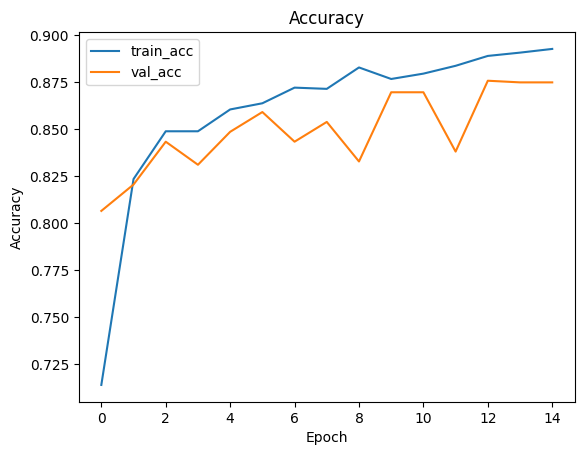

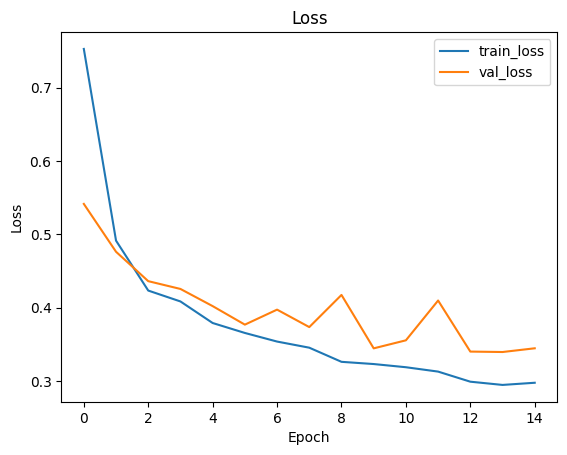

In [ ]:
import matplotlib.pyplot as plt

hist = history.history
plt.figure()
plt.plot(hist["accuracy"], label="train_acc")
plt.plot(hist["val_accuracy"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")

plt.figure()
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")
plt.show()


In [ ]:
# Unfreeze top layers for fine-tuning
base.trainable = True
# Keep most layers frozen; unfreeze only the last 20 layers for stability
for layer in base.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[ckpt, early, reduce]
)


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7945 - loss: 0.5484
Epoch 1: val_accuracy did not improve from 0.87566
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - accuracy: 0.7946 - loss: 0.5482 - val_accuracy: 0.8511 - val_loss: 0.3841 - learning_rate: 1.0000e-05
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8440 - loss: 0.4252
Epoch 2: val_accuracy did not improve from 0.87566
143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 106ms/step - accuracy: 0.8440 - loss: 0.4252 - val_accuracy: 0.8503 - val_loss: 0.3952 - learning_rate: 1.0000e-05
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8631 - loss: 0.3646
Epoch 3: val_accuracy did not improve from 0.87566

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - accuracy: 0.8631 - loss: 0.3647 - val_accuracy: 0.8520 - val_loss: 0.3855 - learning_rate: 1.0000e-05
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc:.4f}  |  Test loss: {test_loss:.4f}")

# Predictions
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_prob = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
cm


Test accuracy: 0.8352  |  Test loss: 0.4159

Classification Report:

              precision    recall  f1-score   support

      glioma       0.86      0.81      0.84       300
  meningioma       0.81      0.55      0.65       306
     notumor       0.91      0.95      0.93       405
   pituitary       0.75      0.99      0.85       300

    accuracy                           0.84      1311
   macro avg       0.83      0.83      0.82      1311
weighted avg       0.84      0.84      0.83      1311



array([[243,  31,   2,  24],
       [ 31, 168,  37,  70],
       [  7,   6, 386,   6],
       [  0,   2,   0, 298]])

True label: glioma


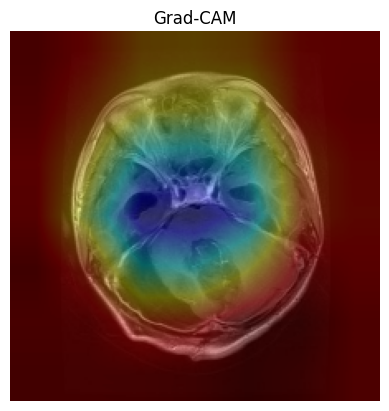

In [ ]:
# === Robust Grad-CAM (Keras 3 compatible) ===
import tensorflow as tf
import numpy as np # Moved import outside the if block
import matplotlib.pyplot as plt
import cv2

backbone = model.get_layer("efficientnetb0")
try:
    last_conv = backbone.get_layer("top_conv")
except ValueError:
    last_conv = None
    for lyr in reversed(backbone.layers):
        try:
            if len(lyr.output.shape) == 4:
                last_conv = lyr
                break
        except Exception:
            pass
assert last_conv is not None, "Couldn't find a conv-like 4D layer inside the backbone."

backbone_multi = tf.keras.Model(
    inputs=backbone.input,
    outputs=[last_conv.output, backbone.output],
    name="backbone_multi"
)

gap   = model.get_layer("global_average_pooling2d")
drop  = model.get_layer("dropout")
dense = model.get_layer("dense")
feat = backbone.output
logits = dense(drop(gap(feat)))
head_model = tf.keras.Model(inputs=backbone.output, outputs=logits, name="head_model")

def make_gradcam_heatmap(raw_batch, class_index=None):
    x_aug = data_augmentation(raw_batch, training=False)
    x_pre = tf.keras.applications.efficientnet.preprocess_input(tf.cast(x_aug, tf.float32))

    with tf.GradientTape() as tape:
        conv_maps, features = backbone_multi(x_pre, training=False)
        preds = head_model(features, training=False)
        if class_index is None:
            class_index = int(tf.argmax(preds[0]))
        class_score = preds[:, class_index]

    grads = tape.gradient(class_score, conv_maps)
    weights = tf.reduce_mean(grads, axis=(1, 2))[0]
    conv_maps_ = conv_maps[0]
    heatmap = tf.reduce_sum(conv_maps_ * weights, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def show_gradcam(orig_image_batch, heatmap, alpha=0.35):
    img = orig_image_batch[0].numpy()
    if img.dtype != np.uint8:
        # import numpy as np # Removed import from here
        img = np.clip(img.astype("float32"), 0, 255).astype("uint8")
    hm = (heatmap * 255).astype("uint8")
    hm = cv2.resize(hm, (img.shape[1], img.shape[0]))
    hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 1 - alpha, hm, alpha, 0)
    plt.figure(); plt.imshow(overlay); plt.axis("off"); plt.title("Grad-CAM")

one = next(iter(test_ds.unbatch().batch(1)))
img, label = one
heatmap = make_gradcam_heatmap(img)
show_gradcam(img, heatmap)
print("True label:", class_names[int(label[0])])

In [ ]:
from tensorflow.keras.preprocessing import image as kimage
import numpy as np
from pathlib import Path

def predict_one(img_path):
    img = kimage.load_img(img_path, target_size=IMG_SIZE)
    arr = kimage.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr = preprocess_input(arr)
    probs = model.predict(arr, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    return class_names[pred_idx], probs[pred_idx], dict(zip(class_names, probs.round(4)))

# Pick any image from the test set:
some_img = next(iter(Path(test_dir).rglob("*.jpg")))
pred, conf, all_probs = predict_one(str(some_img))
print("Image:", some_img)
print("Prediction:", pred, f"({conf:.3f})")
print("All probs:", all_probs)


Image: /content/data/Testing/notumor/Te-no_0196.jpg
Prediction: notumor (0.929)
All probs: {'glioma': np.float32(0.0118), 'meningioma': np.float32(0.0251), 'notumor': np.float32(0.9293), 'pituitary': np.float32(0.0338)}


In [ ]:
# Save to the Colab VM
model.save("brain_tumor_efficientnetb0.keras")

# (Optional) Save to Google Drive to keep it
from google.colab import drive
drive.mount('/content/drive')
!cp brain_tumor_efficientnetb0.keras /content/drive/MyDrive/

MessageError: Error: credential propagation was unsuccessful